# Our prior vs. Doval (2006)

We can turn our nonparametric prior into a nonparametric spectrum using Tobar (2018). Or just calculate the empirical spectrum of samples from our prior.

## Relevant features or facts from Doval (2006)

- Source filter theory is valid up to 4 or 5 kHz, so we really only need sampling rates of 8 kHz.
- GF is low-pass, dGF is thus bandpass with spectral maximum at (by definition) glottal formant.
- Features: GF is differentiable, except sometimes at GCI. dGF is differentiable, except at GCI.

## Spectral rolloff/slope of glottal flow

GF = glottal flow = $U(t)$, dGF = derivative of GF = $u(t) = U'(t)$

The models in Doval (2006) state that the dGF is differentiable, except at GCI.

Empirically: power of GF falls like -12 dB/oct.
Thus power of dGF falls even slower as -6 dB/oct.
This means that the theoretical spectrum of $|u(f)| \sim 1/f$.
A sufficient condition for this to occur is that $u(t)$ is **piecewise continuous** by the Riemann-Lebesgue lemma (see Jaynes 2003, p. 238). And this is indeed the case at GCI if abrupt closure.

However, in case of smooth closure, the other extreme, we have -12 dB/oct rolloff of dGF and -18 dB/oct rolloff of GF.

If we can specify that the derivatives $u^{(p)}(0) = 0$ at *all orders* $(p=0,1,2,\cdots)$ at GOI, then using a RBF kernel with one discontinuity at GCI is in effect the smoothest function that we could use while still having the -6 dB/oct slope, because there is only one discontinuity and all other derivatives exist. [Differentiating GPs](http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf).

**But wait**: $u^{(p)}(0) = 0$ for all $p \in (0,1,\ldots,\infty)$ *completely specifies the function u(t)*. This is an insight from SDE modeling of GPs, and can be seen by the reduction of uncertainty in the covariance matrices. Thus we cannot do this. Our GOI implementation is thus a somewhat ad-hoc compromise.

The logical opposite of that is using a function for $u(t)$ that is made of many piecewise continuous lines: this would still have -6 dB/oct slope. This argument can be expanded to a function that is continuous, but (almost) nowhere differentiable, if the pieces are taken small enough. If it is discontinuous, we would have something like white noise with a zero decay.

## Definite polarity of glottal flow

This *can* in fact be incorporated in a GP. If the pitch period is $T$ then $\mathbb{E}[u(t)u(t+T)] > 0$. The polarity is encoded in a manifestly positive correlation between points along the train which are about $T$ apart.

But which kernel should we use to encode this positive covariance? It is not easy to try different kernels because the positive definitess is easily lost. By accident I did find one possible solution: see below.

So far only repeating the diagonal blocks on the off-diagonal blocks seems to work to encode the fixed polarity of the GF.

It seems like encoding this might also be too much.

Another possibility is using [Hadamard multitask regression in GPyTorch](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Hadamard_Multitask_GP_Regression.html). See [here](https://github.com/cornellius-gp/gpytorch/issues/1833#issuecomment-975550057) for a reference.

NOTES


When the kernels are embedded in zeros (due to windowing), they are not invertible. The kernels themselves are barely invertible, however (typical of RBF kernel). Log det is still possible; it uses LU factorization. Cholesky doesn't work.

One other idea to add more flexibility is to add warping of the input variable $t$, for example $u(t) = at + bt^2$. This can for example be used to stretch the graph of the GF to have longer closed times.

In [1]:
%pylab inline

from scipy.special import erf

Erf = erf
Sqrt = sqrt
Pi = pi

def HeavisidePi(x):
    return piecewise(x, [np.abs(x) <= .5], [1.,0.])

def HeavisideTheta(x):
    return 1.*(x >= 0) # This needs >= for k00() to work properly at c = -0.5

Populating the interactive namespace from numpy and matplotlib


Mean number of level-zero upcrossings for *underlying* RBF kernel
on the unit interval = 0.15915494309189535
154.0584586705497
12.001794238698515
1.044218252727523


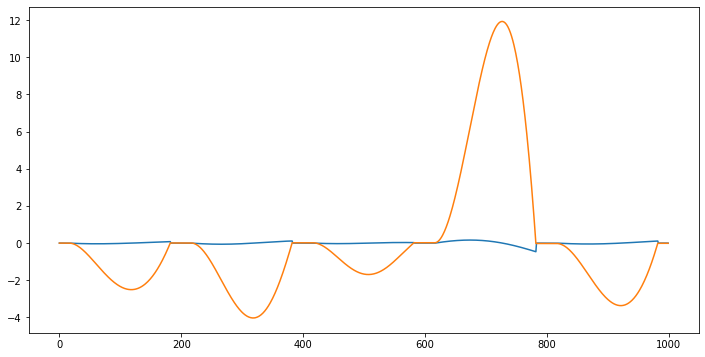

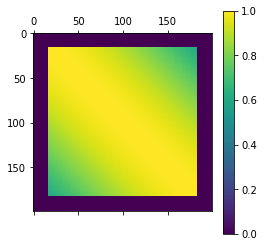

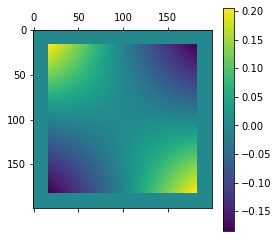

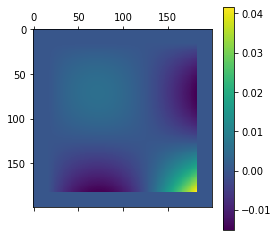

In [2]:
def RBF(dt):
    return exp(-(dt/lam)**2/2)

lam = 1 # Equal to length of boxcar function (HeavisidePi)

# Rasmussen & Williams p. 83
print("Mean number of level-zero upcrossings for *underlying* RBF kernel\non the unit interval =", 1/(2*pi*lam))

def window(t):
    return HeavisidePi(t)

def k(t1, t2):
    dt = np.abs(t1 - t2)
    return window(t1)*RBF(dt)*window(t2)

def sample(K):
    return np.random.multivariate_normal(zeros_like(K)[:,0], K)

n = 200
t = linspace(-.6, .6, n)
#t = linspace(-.45, .45, n)
t1 = t[:,None]
t2 = t[None,:]
K = k(t1, t2)

def k0(x, y):
    def kx(x):
        return Sqrt(Pi/2) * lam * (Erf((1 - 2*x)/(2*Sqrt(2)*lam)) + Erf((1 + 2*x)/(2*Sqrt(2)*lam))) * HeavisidePi(x)
    Zk = lam*(2*(-1 + exp(-1/(2*lam**2)))*lam + sqrt(2*pi)*erf(1/(sqrt(2)*lam)))
    proj = kx(x)*kx(y)/Zk
    return k(x,y) - proj

def k0Approx(x, y): # Works for lam > 0.8
    def kxApprox(x):
        return lam*exp(-6*x**2/(1+12*lam**2))*HeavisidePi(x)/sqrt(1/12+lam**2)
    ZkApprox = sqrt(2*pi)*lam*erf(1/sqrt(2/3+8*lam**2))
    proj = kxApprox(x)*kxApprox(y)/ZkApprox
    return k(x,y) - proj

def k00(x, y):
    c = -0.5
    return k0(x, y) - (1/k0(c, c))*(k0(x, c) @ k0(c, y))

K0 = k0(t1, t2)
K00 = k00(t1, t2)

figure(figsize=(12,6))

for _ in range(1):
    pulses = hstack([sample(K00) for i in range(5)])
    plot(pulses)
    plot(cumsum(pulses))

matshow(K); colorbar(); print(norm(K))
matshow(K0); colorbar(); print(norm(K0))
matshow(K00); colorbar(); print(norm(K00))

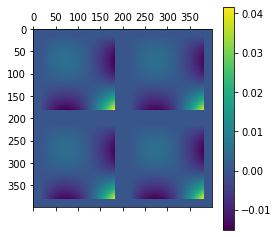

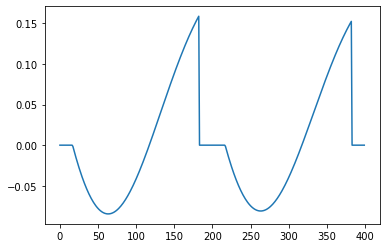

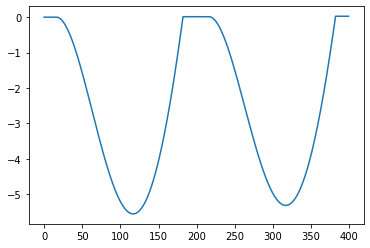

In [3]:
from scipy.linalg import block_diag

n = K00.shape[0]

def positive_cov(t1, t2, scale):
    return exp(-(np.abs(t1-t2)/scale)**2)*window(t1)*window(t2)

def positive_initial_cov(t1, t2, scale):
    return exp(-(np.abs(t1-t2)/scale)**2)*window(t1)*window(t2)

a = .95 # Positive definite as long as |a| <= 1. Negative sign induces opposite polarity
scale = .1
pc = a*positive_cov(t1, t2, scale)

duo = block([
    [K00, a*K00],
    [a*K00, K00]
])
matshow(duo); colorbar(); show()
y = sample(duo)
plot(y); show()
plot(cumsum(y))

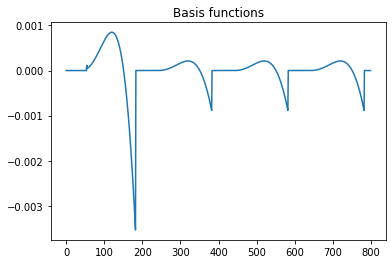

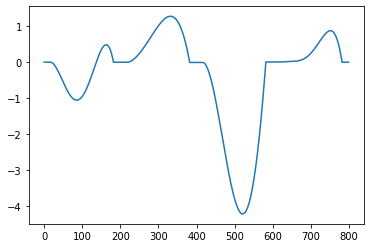

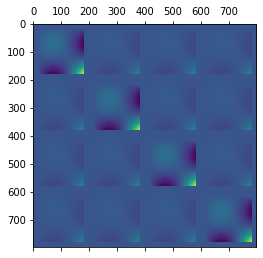

In [87]:
def tiles(a, b, n):
    m = a.shape[0]
    assert a.shape[0] == a.shape[1]
    assert a.shape == b.shape
    
    latent = [b]*n + [b] + [a] + [b] + [b]*n
    blocks = [latent[n+1-i:n+1-i+n] for i in range(n)]
    return block(blocks)

a = 0.25 # Positive definite as long as a <= 1. If a == 1, then identical draws
k_train = tiles(K00, a*K00, 4)

R = cholesky(k_train + np.eye(K.shape[0])*1e-8)
plot(R[:,54]);
#plot(norm(R,axis=0))
title("Basis functions")
figure()

y = sample(k_train)
plot(cumsum(y))
show()
matshow(k_train)

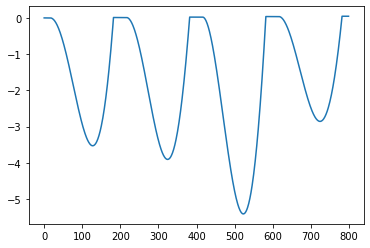

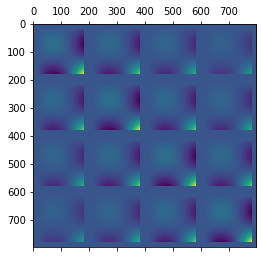

In [89]:
def decaying_tiles(a, c, n):
    m = a.shape[0]
    assert a.shape[0] == a.shape[1]
    
    latent = [(c**i)*a for i in range(1, n+2)]
    latent = latent[::-1] + [a] + latent
    blocks = [latent[n+1-i:n+1-i+n] for i in range(n)]
    return block(blocks)

c = .75
k_train = decaying_tiles(K00, c, 4)
y = sample(k_train)
plot(cumsum(y))
show()
matshow(k_train)

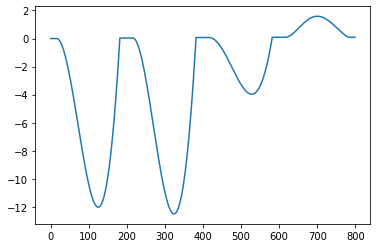

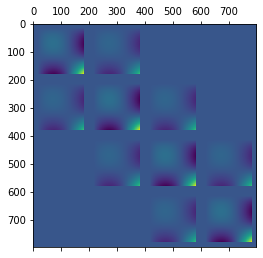

In [97]:
def tri_tiles(a, b, n):
    m = a.shape[0]
    assert a.shape[0] == a.shape[1]
    assert a.shape == b.shape
    
    z = zeros((m, m))
    
    latent = [z]*n + [b] + [a] + [b] + [z]*n
    blocks = [latent[n+1-i:n+1-i+n] for i in range(n)]
    return block(blocks)

a = .6 # The fact that only nearest neighbours are correlated (and neighbours further away
       # have zero correlation) limits the extent of the covariance between the nearest
       # neighbours if a positive definite covariance matrix is to be had. For example,
       # neighbours cannot be completely identical, unlike the above dense example with tiles()
k_train = tri_tiles(K00, a*K00, 4)
y = sample(k_train)
plot(cumsum(y))
show()
matshow(k_train)

<ipython-input-2-d89c307c7150>:17: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(zeros_like(K)[:,0], K)


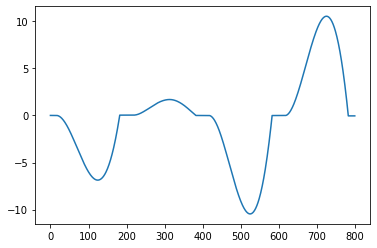

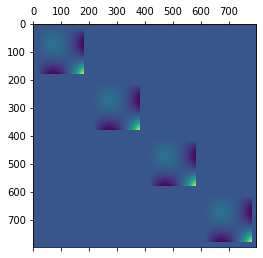

In [7]:
k_rbf = tiles(K00, .0000005*positive_cov(t1, t2, .1), 4)
y = sample(k_rbf)
plot(cumsum(y))
show()
matshow(k_rbf)